In [36]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Funnynet

## A neural network that makes jokes

Special thanks to taivop for providing the [dataset](https://github.com/taivop/joke-dataset).

This notebook is heavily inspired by [fastai NLP work](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb).

In [37]:
import pdb
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [38]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
EOJ = 'xeoj'  # end of joke tag

PATH=Path('data')

In [39]:
files = list(PATH.iterdir())
print(files)

[WindowsPath('data/reddit_jokes.json'), WindowsPath('data/stupidstuff.json')]


In [40]:
dataset = files[0]
jokes = json.load(open(dataset))

In [41]:
len(jokes)

194553

In [42]:
jokes[0]

{'body': 'Now I have to say "Leroy can you please paint the fence?"',
 'id': '5tz52q',
 'score': 1,
 'title': 'I hate how you cant even say black paint anymore'}

Let's discard all the jokes that have 0 score, as they aren't that helpful for training

In [43]:
rated_jokes = [joke for joke in jokes if joke['score'] > 0]

In [44]:
len(rated_jokes)

132992

In [45]:
scores = [joke['score'] for joke in rated_jokes]
np.mean(scores),np.max(scores)

(172.94791416025024, 48526)

Let's see how many jokes have really high scores:

In [46]:
len([score for score in scores if score>5000])

1067

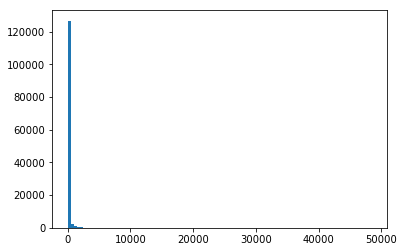

In [47]:
plt.hist(scores, bins=100);

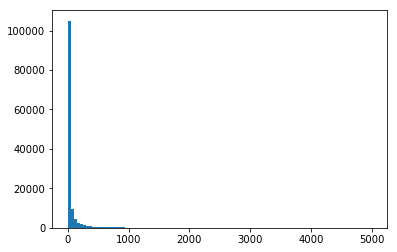

In [48]:
low_scores = [score for score in scores if score<5000]
plt.hist(low_scores, bins=100);

Looks like there's quite a dropoff of scores, almost none above 1000. Score normalization or something might be useful -- a large amount of the score is probably due to posting time, so it might be valuable to batch all the score into "unpopular", "semi-popular", and "very popular" or something.

Next up, let's combine all the jokes in title->body format.

In [49]:
title_body = [joke['title']+' '+joke['body'] for joke in rated_jokes]
title_body[0]

'I hate how you cant even say black paint anymore Now I have to say "Leroy can you please paint the fence?"'

Horrible, but formatted correctly. Now, let's combine all the jokes into one long string. This will destroy any ability for the network to understand what the baginning or end of a joke is, but I'll come back to that. 

In [50]:
text = ''
for joke in title_body:
    text = text + ' ' + joke + ' ' + EOJ + ' '
    if len(text) > 700000: 
        break

In [51]:
len(text)

700013

In [52]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 124


In [53]:
chars.insert(0, "\0")
print(chars)

['\x00', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x9d', '\xa0', '¢', '£', '°', '´', 'è', 'é', 'ñ', 'ó', 'μ', 'π', '–', '—', '‘', '’', '“', '”', '•', '…', '€', '√', '∫', '\ufeff', '🇩', '🇰', '😂', '😨', '🤣']


It appears there are Emojis in the dataset. 

In [54]:
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

In [55]:
idx = [char_indices[c] for c in text]

idx[:10]

[3, 44, 3, 75, 68, 87, 72, 3, 75, 82]

In [56]:
''.join(indices_char[i] for i in idx[:70])

' I hate how you cant even say black paint anymore Now I have to say "L'

# Emojis in Jokes

How many of them have them?

In [57]:
emojis = chars[-3:]

def containsEmoji(joke):
    for emoji in emojis:
        if emoji in joke:
            return True
    return False

#type(title_body[0])
contains_emoji = [joke for joke in title_body if containsEmoji(joke)]
print(len(contains_emoji))
contains_emoji

21


["Shorty! Yo' momma is so short, I can see her feet in her driver's license. \n\n😂🤣😂🤣😂🤣",
 'Golf balls A man got on the bus with both of his front trouser pockets full of golf balls and sat down next to a beautiful blonde.\n\nThe puzzled blonde kept looking at him and his bulging pockets.\n\nFinally, after many glances from her, he said, "It\'s golf balls."\n\nThe blonde continued to look at him for a very long time, thinking deeply about what he had said.\n\nFinally, unable to contain her curiosity any longer, she asked,\n\n"Does it hurt as much as tennis elbow..?"  :)😨😨😨😨😨😨',
 'What do you get if your pour hot water down a rabbit hole? Hot-Cross bunnies! 😂',
 'Why did the scarecrow win an award? He was outstanding in his field 😂',
 'Prince Charles and the hooker... Prince Charles and the Hooker: 4 years ago Prince Charles decided to take up walking every day. At the same street corner he passed a hooker standing there every day. He learned to brace himself as he approached her for wh

So not that many. 
Interestingly though, there seems to be more emojis than we found initially. 